In [1]:
# Telling matplotlib to work in the program and not as an external window
%matplotlib inline                  
from nptdms import TdmsFile           # Handling TDMS files
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib as mpl
import numpy as np
from numpy import *
import os, sys                       # For all the stuff which has to do with   
import skimage
from skimage import morphology
from skimage.util import invert
import pandas as pd
import matplotlib.cm as cm
import time
from statistics import mode
from copy import deepcopy            # To completely copy lists and not references
import cv2                           # OpenCV for video and image procedures
                                   # generating a folder or deleting files, etc.
import multiprocessing as mp         # This is for preventing large videos to take too much internal memory
import shutil                        # Deleting folders
from pandas import DataFrame, Series  # for convenience
from scipy.optimize import curve_fit
plt.rcParams.update({'font.size': 16})

def loadTDMSImages(file):
    global exposure, dimx, dimy
    tdms_file = TdmsFile(file)
    p=tdms_file.object().properties   
    dimx=int(p['dimx'])  
    dimy=int(p['dimy'])
    frames=int(p['dimz'])
    exposure=float(p['exposure'])
    images=tdms_file.channel_data('Image','Image')
    return images.reshape(frames,dimx,dimy)

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def autocorrFFT(x):
    N=len(x)
    F = np.fft.fft(x, n=2*N)  #2*N because of zero-padding
    PSD = F * F.conjugate()
    res = np.fft.ifft(PSD)
    res= (res[:N]).real   #now we have the autocorrelation in convention B
    n=N*np.ones(N)-np.arange(0,N) #divide res(m) by (N-m)
    return res/n #this is the autocorrelation in convention A

def msd_fft(r):
    N=len(r)
    D=np.square(r).sum(axis=1) 
    D=np.append(D,0) 
    S2=sum([autocorrFFT(r[:, i]) for i in range(r.shape[1])])
    Q=2*D.sum()
    S1=np.zeros(N)
    for m in range(N):
        Q=Q-D[m-1]-D[N-m]
        S1[m]=Q/(N-m)
    return S1-2*S2

In [2]:
number='1'
folder = "."
#folder = "/Users/alex/Documents/Measurements/200205 - BM"
dt=0.07
pxtomum=0.0533#0.0719e-6
offset = 12
maxpower = 1.2
analyzethevideo = True

R = 2.19e-6/2
T = 273.15+20.3
kB = 1.38064852e-23
eta=2.414e-5*10**(247.8/(T-140))
D_0 = kB*T/(6*np.pi*eta*R)
start_time = time.time()   
if analyzethevideo == True:
    images = loadTDMSImages(folder+"/Brownian motion_00"+str(number)+"_video.tdms")
    videosize = len(images[0])
# File name of the original measurement data
else:
    tdms_file = TdmsFile(folder+"/Brownian motion_00"+str(number)+"_PN.tdms")
    videosize = 1000
    Nfound = tdms_file.channel_data('PN','N')
    Xc = tdms_file.channel_data('PN','Xc')
    Yc = tdms_file.channel_data('PN','Yc')
    xolaser = tdms_file.channel_data('PN','Xh')
    yolaser = tdms_file.channel_data('PN','Yh')
    maxlength = len(Nfound)
print("--- %s seconds ---" % round((time.time() - start_time),2))

--- 37.08 seconds ---


In [27]:
if analyzethevideo == True:
    threshold = 3000
    spots = pd.DataFrame()
    for i, image in enumerate(images):
        processed_image = image > threshold  # threshold image
        processed_image = invert(processed_image)
        label_image = skimage.measure.label(processed_image)
        m=0
        for region in skimage.measure.regionprops(label_image, intensity_image=image):
            if region.area < 10 or region.area > 3000: # do not add spot
                continue
            spots = spots.append([{'y': region.centroid[0],
                                   'x': region.centroid[1],
                                   'area': region.area,
                                   'frame': i,
                                   'number': m}])
            m+=1

    print('Total particles found = ',len(spots))
    print('Length = ',max(spots['frame']))
    maxlength = max(spots['frame'])
    #Xclength = len(spots)
    #Xc = np.zeros(Xclength); Yc = np.zeros(Xclength)
    Xc = np.asarray(spots['x'])
    Yc = np.asarray(spots['y'])
    Nfound = np.zeros(maxlength)
    for i in range(maxlength): Nfound[i] = max(spots.loc[(spots['frame']==i),'number'])+1        
    maxparticle = int(max(Nfound))

Total particles found =  2000
Length =  999


In [33]:
    particles1 = np.zeros((maxlength,maxparticle,3))
    count = 0
    for i in range(maxlength):
        for j in range(int(Nfound[i])):
            particles1[i,j,0] = Xc[count]
            particles1[i,j,1] = Yc[count]
            count += 1

    for i in range(maxlength):
        for j in range(int(Nfound[i])):
            if particles1[i,j,0] == 0:
                particles1[i,j,0] = np.nan
                particles1[i,j,1] = np.nan

    realparticle = int(mode(Nfound))
    particles = np.zeros((maxlength,realparticle,3))
    particles[0,0:realparticle,0] = particles1[0,0:realparticle,0]
    particles[0,0:realparticle,1] = particles1[0,0:realparticle,1]

    lastnonzero = np.zeros(realparticle)
    for i in range(1,maxlength):
        for j in range(realparticle):
            shortest = 10           
            for k in range(int(Nfound[i])):
                if particles1[i,k,2] == 0:
                    dist = np.sqrt(pow(particles1[i,k,0]-particles[int(lastnonzero[j]),j,0],2)+pow(particles1[i,k,0]-particles[int(lastnonzero[j]),j,0],2))
                    #print('i = ',i,' - k = ',k,' - dist = ',round(dist,2))
                    if dist < shortest:
                        shortest = dist
                        where = k
            if shortest != 10:
                particles[i,j,0] = particles1[i,where,0]
                particles[i,j,1] = particles1[i,where,1]
                lastnonzero[j] = i
                particles1[i,where,2] = 1

    for i in range(1,maxlength):
        for j in range(realparticle):
            if particles[i,j,0] == 0:
                particles[i,j,0] = np.nan
                particles[i,j,1] = np.nan
                
    trajlength = np.zeros(number)
    for j in range(number):
        lastfound = 0; out = True
        for i in range(1,maxlength):
            if out == True:
                if particles[i,j,0] != particles[i,j,0]:
                    lastfound = int(i-1)
                    count = 1; check = True
                    while check == True:
                        if particles[lastfound+count,j,0] == particles[lastfound+count,j,0]:
                            #print('j = ',j,' - i = ',i,' - gap = ',count)
                            check = False
                        else: count +=1
                        if count == 20:
                            print('Failed at j = ',j,' - i = ',i)
                            check = False
                            trajlength[j] = lastfound
                            particles[lastfound:,j,0] = np.nan
                            particles[lastfound:,j,1] = np.nan
                            out = False
                    if out == True:
                        for k in range(1,count+1):
                            particles[lastfound+k,j,0] = particles[lastfound,j,0]+(k/(count+1))*(particles[lastfound+count,j,0]-particles[lastfound,j,0])
                            particles[lastfound+k,j,1] = particles[lastfound,j,1]+(k/(count+1))*(particles[lastfound+count,j,1]-particles[lastfound,j,1])
                            particles[lastfound+k,j,2] = particles[lastfound,j,2]+(k/(count+1))*(particles[lastfound+count,j,2]-particles[lastfound,j,2])
                            particles[lastfound+k,j,3] = particles[lastfound,j,3]+(k/(count+1))*(particles[lastfound+count,j,3]-particles[lastfound,j,3])
                if i == maxlength-1: 
                    trajlength[j] = i
    print(' ')
    print('Trajectory length')                  
    print(trajlength)

Fill gaps at:
 
Trajectory length
[ 998.  998.]


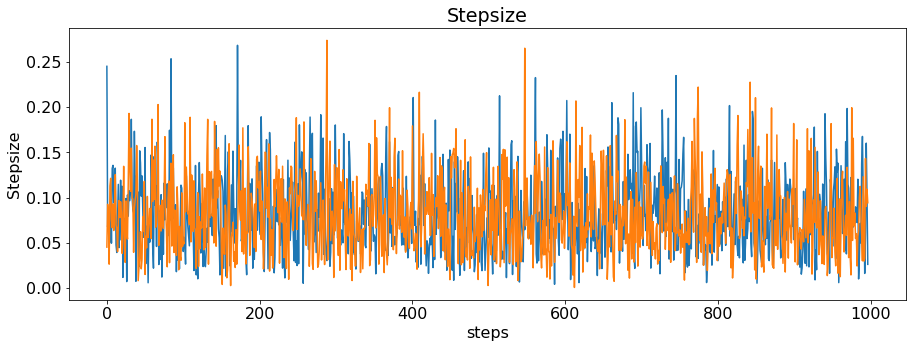

In [34]:
distance=np.zeros((maxlength,realparticle))
for j in range(realparticle):
    for i in range(1,int(trajlength[j])):
        distance[i,j]=np.sqrt(pow(particles[i,j,0]-particles[i-1,j,0],2)+pow(particles[i,j,1]-particles[i-1,j,1],2))*pxtomum

fig=plt.figure(1, figsize = (15,5) )
plt.title('Stepsize')
plt.xlabel('steps')
plt.ylabel('Stepsize')
#plt.plot(distance[450:500,i])
for i in range(realparticle):
    #plt.plot(distance[1:,i])
    plt.plot(distance[1:int(trajlength[i]),i])
plt.show()

check=0
for i in range(maxlength):
    if particles[i,0,0] != particles[i,0,0]:
        if check == 0:
            #print('Still problems at')
            check = 1
        #print('i = ',i)

(array([ 168.,  381.,  263.,  131.,   44.,    8.,    3.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.]),
 array([ 0.  ,  0.04,  0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,
         0.36,  0.4 ,  0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,
         0.72,  0.76,  0.8 ,  0.84,  0.88,  0.92,  0.96]),
 <a list of 24 Patch objects>)

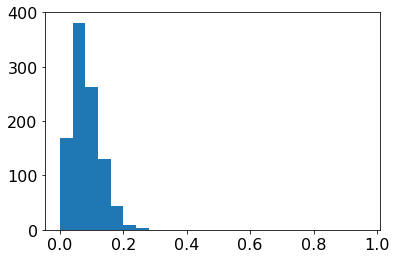

In [35]:
bins = np.linspace(0,1,25,endpoint=False)
plt.hist(distance[:int(trajlength[0]),0],bins = bins)

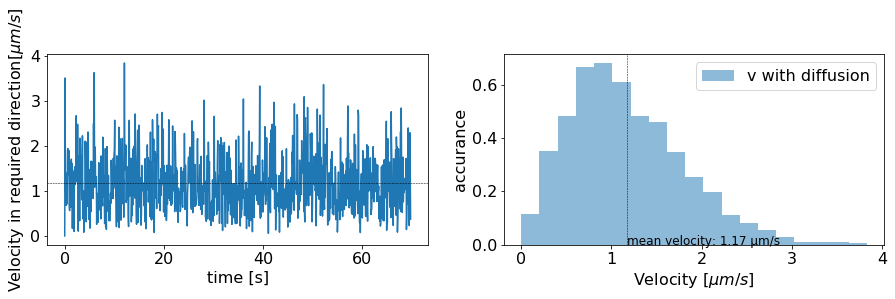

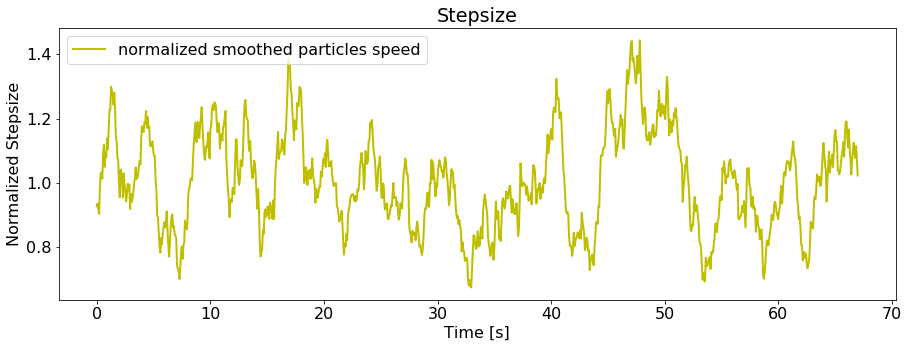

single particle =  1.168  +-  0.396  µm/s   max velocity =  3.836   µm/s


In [39]:
which = 0
maxlength = int(trajlength[which])
timewave = np.linspace(0,dt*maxlength,maxlength,endpoint = False)

prefactor = np.sqrt(2*D_0*dt)                 #value for calculation of the random steps
xsteps = np.zeros(10*maxlength); ysteps = np.zeros(10*maxlength) #Create random steps
xsteps[:]=prefactor*np.random.normal(0,1,10*maxlength)
ysteps[:]=prefactor*np.random.normal(0,1,10*maxlength)
theopath = np.zeros((10*maxlength,3))
for i in range(10*maxlength):
    theopath[i,0] += xsteps[i]
    theopath[i,1] += ysteps[i]
    if i>0:
        theopath[i,2] = np.sqrt(pow(theopath[i,0]-theopath[i-1,0],2)+pow(theopath[i,1]-theopath[i-1,1],2))/dt

particlesdisplay=particles.copy()
particlesdisplay=(particlesdisplay-videosize/2)*pxtomum
velocitywithdiffusion=np.zeros(maxlength)
movingvector = np.zeros((maxlength,2))
for i in range(1,maxlength):                           #Calc projection of the velocity in the required direction
    movingvector[i,0] = particlesdisplay[i,which,0]-particlesdisplay[i-1,which,0]
    movingvector[i,1] = particlesdisplay[i,which,1]-particlesdisplay[i-1,which,1]
velocitywithdiffusion[:] = np.sqrt(pow(movingvector[:,0],2)+pow(movingvector[:,1],2))/dt 
binwave=np.linspace(min(velocitywithdiffusion),max(velocitywithdiffusion),20)

fig=plt.figure(1, figsize = (15,3.5) )
plt.subplot(1,2,1)
plt.xlabel('time [s]')
plt.ylabel('Velocity in required direction[$\mu m/s$]')
plt.plot(np.arange(maxlength)*dt,velocitywithdiffusion)
plt.axhline(y=np.mean(velocitywithdiffusion),linewidth=0.5, color = 'k',linestyle='--')

plt.subplot(1,2,2)
plt.hist(velocitywithdiffusion, bins=binwave,alpha = 0.5,label='v with diffusion',density='True')
#plt.hist(theopath[:,2]*1e6, bins='auto',alpha = 0.5,label='v theory',density='True')
plt.axvline(x=np.nanmean(velocitywithdiffusion),linewidth=0.5, color = 'k',linestyle='--')
#plt.axvline(x=np.mean(theopath[:,2])*1e6,linewidth=0.5, color = 'k',linestyle='--')
plt.xlabel('Velocity [$\mu m/s$]')
plt.ylabel('accurance')
plt.text(np.nanmean(velocitywithdiffusion),0,'mean velocity: {:.2f} µm/s'.format(np.nanmean(velocitywithdiffusion)),fontsize=12)
#plt.text(np.mean(theopath[:,2])*1e6,0.1,'theory: {:.2f} µm/s'.format(np.mean(theopath[:,2])*1e6),fontsize=12)
plt.savefig('Histogram Stepsize'+str(number)+'.pdf', format='pdf')
plt.legend()
plt.show() 

fig=plt.figure(1, figsize = (15,5) )
plt.title('Stepsize')
plt.xlabel('Time [s]')
plt.ylabel('Normalized Stepsize')
smoothvalue = 20
smoothit = smooth(velocitywithdiffusion,smoothvalue)
xsmooth=np.linspace(0,dt*maxlength-2*smoothvalue*dt,maxlength-2*smoothvalue,endpoint=False)
#plt.plot(xsmooth,smoothit[smoothvalue:maxlength-smoothvalue]/max(smoothit), 'y-', lw=2,label='normalized smoothed particles speed')
plt.plot(xsmooth,smoothit[smoothvalue:maxlength-smoothvalue]/mean(smoothit), 'y-', lw=2,label='normalized smoothed particles speed')
#plt.plot(xsmooth,velo[smoothvalue:maxlength-smoothvalue], 'r-', lw=2,label='normalized required speed')
plt.legend()
plt.savefig('Stepsize vs time'+str(number)+'.pdf', format='pdf')
plt.show()

np.savetxt('Datavelo'+str(number)+'.txt', np.transpose([velocitywithdiffusion,smoothit]),fmt='%1.6f')
print('single particle = ',round(np.nanmean(velocitywithdiffusion),3),' +- ',round(var(velocitywithdiffusion),3),' µm/s   max velocity = ',round(max(velocitywithdiffusion),3),'  µm/s')

1.16755752633


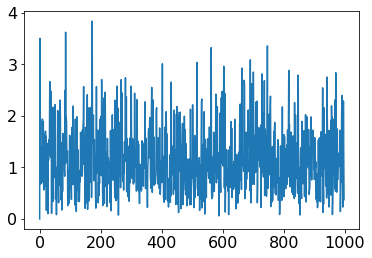

In [41]:
stepsize = np.zeros(maxlength)
for i in range(1,maxlength):
    stepsize[i] = np.sqrt(pow(particles[i,which,0]-particles[i-1,which,0],2)+pow(particles[i,which,1]-particles[i-1,which,1],2))

plt.plot(stepsize*pxtomum/dt)
print(np.nanmean(stepsize*pxtomum/dt))

/Users/alex/anaconda/lib/python3.5/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


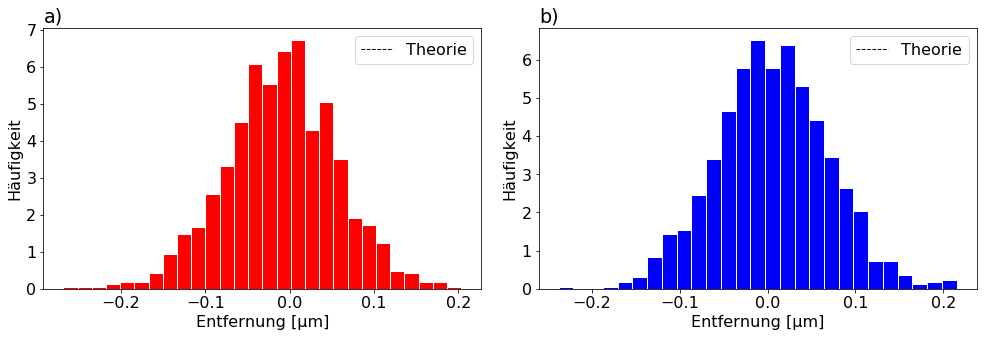

 D  theory =  1.9738151474177028e-13
 Dx exp sig=  1.97381514742e-13
 Dy exp sig=  1.97381514742e-13
Drift x =  0.0  nm - y =  0.0  nm


In [42]:
def curve(r,sigma,mu): return 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(r - mu)**2/(2*sigma**2))

def curve2(r):
    return 1/np.sqrt(4*np.pi*D_0*dt) * np.exp(-(r - mu)**2/(4*D_0*dt))
#sigma=prefactor
mu=0
def curve3(r,A,sigma,mu):
    return A * np.exp(-(r - mu)**2/(sigma))

realxsteps = np.zeros(maxlength);realysteps = np.zeros(maxlength)
for i in range(1,maxlength):
    realxsteps[i] = (particlesdisplay[i,which,0]-particlesdisplay[i-1,which,0])
    realysteps[i] = (particlesdisplay[i,which,1]-particlesdisplay[i-1,which,1])

fig=plt.figure(1, figsize = (14,5) )
plt.subplot(1,2,1)
histo, bins, patches = plt.hist(realxsteps,bins='auto',normed=1,color='r',edgecolor="#FFFFFF");
rscale=np.linspace(bins[0],bins[len(bins)-1],100)
plt.plot(rscale,curve2(rscale),'k--',lw=1,label='Theorie') 
fitbins = np.zeros(len(bins)-1)
for i in range(len(bins)-1):
    fitbins[i] = (bins[i]+bins[i+1])/2
popt,pcov = curve_fit(curve3, fitbins, histo,p0 = (1/np.sqrt(4*np.pi*D_0*dt),4*D_0*dt,mu))
pErr = np.sqrt(np.diag(pcov))
plt.plot(rscale,curve3(rscale,*popt),'k-',lw=1) 
savex = popt
plt.title('a)', loc = 'left')
plt.xlabel('Entfernung [µm]')#$\mu$
plt.ylabel('Häufigkeit')
plt.legend()

plt.subplot(1,2,2)
histo, bins, patches = plt.hist(realysteps,bins='auto',normed=1,color='b',edgecolor="#FFFFFF");
rscale=np.linspace(bins[0],bins[len(bins)-1],100)
plt.plot(rscale,curve2(rscale),'k--',lw=1,label='Theorie') 
fitbins = np.zeros(len(bins)-1)
for i in range(len(bins)-1):
    fitbins[i] = (bins[i]+bins[i+1])/2
popt,pcov = curve_fit(curve3, fitbins, histo,p0 = (1/np.sqrt(4*np.pi*D_0*dt),4*D_0*dt,mu))
pErr = np.sqrt(np.diag(pcov))
plt.plot(rscale,curve3(rscale,*popt),'k-',lw=1) 
savey = popt
plt.title('b)', loc = 'left')
plt.xlabel('Entfernung [µm]')#$\mu$
plt.ylabel('Häufigkeit')
plt.legend()
plt.tight_layout()
plt.show()


print(' D  theory = ',D_0)
print(' Dx exp sig= ',abs(savex[1])/(4*dt) )
print(' Dy exp sig= ',abs(savey[1])/(4*dt) )
print('Drift x = ',round(savex[2]*1e9,2),' nm - y = ',round(savey[2]*1e9,2),' nm')
#print(' D exp pre= ',1/(4*np.pi*dt*pow(savex[0],2)))

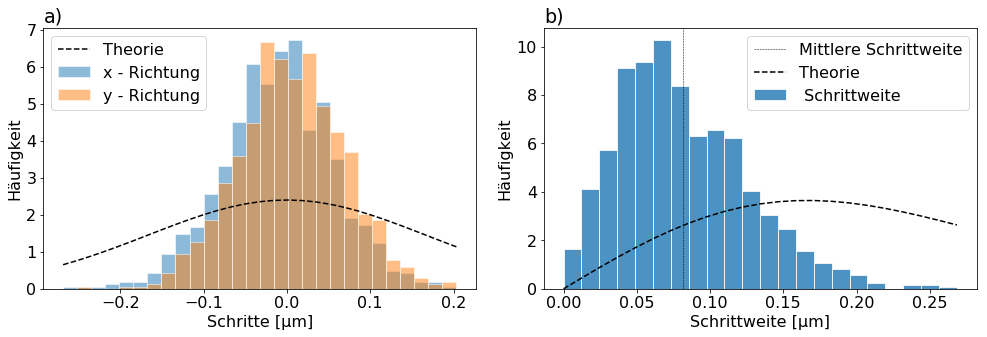

mean step size =  0.082  µm


In [43]:
sigma=prefactor
mu=0
steplength = np.sqrt(pow(realxsteps[:],2)+pow(realysteps[:],2))

fig=plt.figure(1, figsize = (14,5) )
plt.subplot(1,2,1)
histo, bins, patches = plt.hist(realxsteps[:],bins='auto',density=1,label = 'x - Richtung',alpha = 0.5, edgecolor="#FFFFFF")
rscale=np.linspace(bins[0],bins[len(bins)-1],len(bins)) 
rscalem=np.linspace(bins[0]*1e-6,bins[len(bins)-1]*1e-6,len(bins)) 
histo, bins, patches = plt.hist(realysteps[:],bins=rscale,density=1,label = 'y - Richtung',alpha = 0.5, edgecolor="#FFFFFF")
plt.plot(rscale,curve(rscalem,sigma,mu)*1e-6,'k--',lw=1.5,label='Theorie')
plt.title('a)', loc='left')
plt.xlabel('Schritte [µm]')
plt.ylabel('Häufigkeit')
plt.legend()

sigma = np.sqrt(2*D_0*dt)
plt.subplot(1,2,2)
histo, bins, patches = plt.hist(steplength,bins='auto',density=1,label = ' Schrittweite',alpha = 0.8, edgecolor="#FFFFFF")
plt.axvline(x=np.mean(steplength),linewidth=0.5, color = 'k',linestyle='--',label='Mittlere Schrittweite')
rscale2=np.linspace(bins[0],bins[len(bins)-1],len(bins)) 
rscale2m=np.linspace(bins[0]*1e-6,bins[len(bins)-1]*1e-6,len(bins)) 
plt.plot(rscale2,rscale2m/sigma**2*np.exp(-rscale2m**2/(2*sigma**2))*1e-6,'k--',lw=1.5,label='Theorie')
plt.title('b)', loc='left')
plt.xlabel('Schrittweite [µm]')
plt.ylabel('Häufigkeit')
plt.legend()
plt.tight_layout()
plt.savefig('SchrittweiteGemessen.pdf')
plt.show()

meanstepsize = np.mean(steplength)
print('mean step size = ',round(meanstepsize,3),' µm')

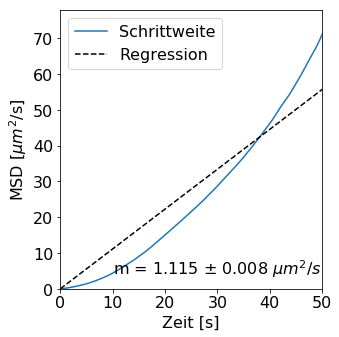

In [44]:
def msd_1d(x):
    result = np.zeros_like(x)
    for i in range(1,len(x)):
        result[i] = np.average((x[i:] - x[:-i])**2)
    return result

def msd_2d(x,y):
    result = np.zeros_like(x)
    for i in range(1,len(x)): result[i] = np.average(pow(x[i:] - x[:-i],2)+pow(y[i:] - y[:-i],2))
    return result

length, maxpoint = 50, 50

def linfunction(xpoints,minput):
    return minput * xpoints


result3 = msd_2d(particlesdisplay[:maxlength,which,0],particlesdisplay[:maxlength,which,1])
plotlength = maxlength
plotlength2 = maxlength*dt
fig=plt.figure(1, figsize = (5,5) )
plt.plot(timewave,result3,label='Schrittweite')
plt.xlabel('Zeit [s]')
plt.ylabel('MSD [$µm^{2}$/s]')
endtime = 50
plt.xlim([0,int(endtime)])
plt.ylim([0.9*min(result3[1:int(endtime/dt)]),1.1*max(result3[:int(endtime/dt)])])
popt,pcov = curve_fit(linfunction, timewave[:int(endtime/dt)], result3[:int(endtime/dt)],p0 = (1))      #FITTING
pErr = np.sqrt(np.diag(pcov))
plt.plot(timewave,linfunction(timewave,*popt),'k--',label='Regression')
plt.text(10,4,'m = '+str(round(popt[0],3))+' $\pm$ '+str(round(pErr[0],3))+' $\mu m^{2}/s$')
plt.legend()
plt.tight_layout()
plt.savefig('MSDmy'+str(number)+'.pdf', format='pdf')
plt.show() 


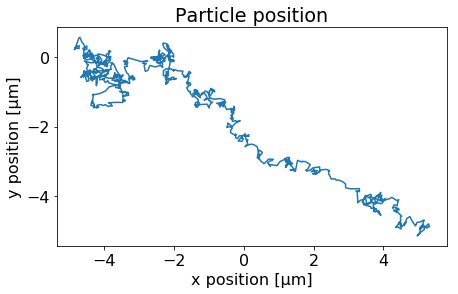

In [45]:
x = particlesdisplay[smoothvalue:maxlength-smoothvalue,which,0]
y = particlesdisplay[smoothvalue:maxlength-smoothvalue,which,1]
v = smoothit[smoothvalue:maxlength-smoothvalue]

fig, ax = plt.subplots(figsize=(7,7))
col_map = plt.get_cmap('viridis')
#ax.scatter(x,y,c=v,linewidths=0.5)
ax.plot(x,y)
ax = plt.gca()
#circle2 = plt.Circle((0, 0), boundaryradius*pxtomum, color='g', fill=False)
#ax.add_artist(circle2)
plt.title('Particle position')
plt.xlabel('x position [µm]')
plt.ylabel('y position [µm]')
#plt.xlim(-(boundaryradius+20)*pxtomum, (boundaryradius+20)*pxtomum)
#plt.ylim(-(boundaryradius+20)*pxtomum, (boundaryradius+20)*pxtomum)
#c_map_ax = fig.add_axes([0.9, 0.1, 0.05, 0.8])
#norm = mpl.colors.Normalize(vmin=min(v), vmax=max(v))
#mpl.colorbar.ColorbarBase(c_map_ax, cmap=col_map, orientation = 'vertical',norm=norm)
#plt.ylabel('Stepsize')
ax.set_aspect('equal')
plt.savefig('Path of the particle colored'+str(number)+'.pdf', format='pdf')
plt.show()

In [100]:
string_images = folder+"/Test_0"+str(number)+"_movie.tdms"
# Folder (!) containing the feature data, if just a video should be generated without features, this string have to be empty
string_folder = ''
if not string_folder == '':
    string_folder += '/'
    with_features = 1
else:
    with_features = 0    
# Frame rate of the generated movie (in frames per second)
Frame_Rate_Movie = 1/dt
# Getting the folder where the measurement data are stored in
place = 0
for i in range(len(string_images)):
    if string_images[i] == '/':
        place = i
folder = string_images[0:place + 1]
if with_features == 0:
    string_folder = folder

# Opens TDMS files and stores the main properties as well as the image series in variables, lists
tdms_file = TdmsFile(string_images)
# All information from the corresponding file
file_info = tdms_file.object()
# Getting the properties of the TDMS file, the strings come from the program 
# generating the TDMS files
temp = file_info.properties
pixel_x = int(temp['dimx'])    # Converting the properties to integers
pixel_y = int(temp['dimy'])
# Saves the number of frames which were adjusted before
number_frames_adjusted = int(temp['dimz'])
parameters = np.zeros(5)
parameters[0] = float(temp['exposure'])    # Saving the exposure time, [s]
parameters[1] = int(temp['binning'])
parameters[2] = int(pixel_x)
parameters[3] = int(pixel_y)
# Getting the image data
image = tdms_file.channel_data('Image', 'Image')
# Getting the number of frames really recorded
number_frames = int(image.shape[0]/pixel_x/pixel_y)
parameters[4] = number_frames
# Generating the image series
series = image.reshape(number_frames, pixel_x, pixel_y)

if with_features == 1:
    # Open the feature files
    files = os.listdir(string_folder)
    for i in range(len(files)):
        # Opening the x-data
        if files[i][0] == 'x':
            x_data = np.array([])
            with open(string_folder + files[i], "rb") as x_dat:
                while 1:
                    try:
                        x_data = np.append(x_data, pickle.load(x_dat))
                    except EOFError:
                        break
        # Opening the y-data
        if files[i][0] == 'y':
            y_data = np.array([])
            with open(string_folder + files[i], "rb") as y_dat:
                while 1:
                    try:
                        y_data = np.append(y_data, pickle.load(y_dat))
                    except EOFError:
                        break
    
        # Opening the file containing the number of particles which is then used for reshaping the two arrays from above
        if files[i][0:3] == 'max':
            number_particles = np.array([])
            with open(string_folder + files[i], "rb") as num:
                while 1:
                    try:
                        number_particles = np.append(number_particles, pickle.load(num))
                    except EOFError:
                        break
    
        # Taking care that probably not all of the original data were taken in the previous program
        if files[i][0:8] == 'range_of':
            range_data = np.array([])
            with open(string_folder + files[i], "rb") as r:
                while 1:
                    try:
                        range_data = np.append(range_data, pickle.load(r))
                    except EOFError:
                        break
            lower_bound = int(range_data[0])
            upper_bound = int(range_data[1])
        
            series = series[lower_bound:upper_bound]
            number_frames = len(series)

        # Taking care that probably only a substack is loaded
        if files[i][0:11] == 'range_stack':
            range_data = np.array([])
            with open(string_folder + files[i], "rb") as r:
                while 1:
                    try:
                        range_data = np.append(range_data, pickle.load(r))
                    except EOFError:
                        break
            lower_bound = int(range_data[0])
            upper_bound = int(range_data[1])
        
            series = series[lower_bound:upper_bound]
            number_frames = len(series)
            
    # Generating the original shape of the data
    x_data = x_data.reshape(int(len(x_data)/number_particles[0]), int(number_particles[0]))
    y_data = y_data.reshape(int(len(y_data)/number_particles[0]), int(number_particles[0]))

KeyboardInterrupt: 

In [ ]:
# Generating the movie
radiusparticle = 5 # Radius of the circles drawn
radiuslaser = 5
colorwave = cm.rainbow(np.linspace(0, 1, maxparticle))

# Working function generating the images, cf. below.
def worker():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlim([0, pixel_x])
    ax.set_ylim([0, pixel_y])
    plt.axis('off')
    im = plt.imshow(series_copy[i,:,:], cmap=plt.get_cmap('gray'))

    circletwo = plt.Circle((trackedx[i,0],trackedy[i,0]), radius=radiusparticle, color='r')
    ax.add_artist(circletwo)

    circlelaser = plt.Circle((xlaser[i,0],ylaser[i,0]), radius=radiuslaser, color='y')
    ax.add_artist(circlelaser)
        
    fig.savefig(string_temp + '/test ' + str(i) + '.png')
    plt.close(fig)

# Folder containing the movie
if not os.path.exists(string_folder + str('Movie')):
    os.makedirs(string_folder + str('Movie'))
# Temporary folder containing the images. Is going to be removed after the preparation of the movie
string_temp = string_folder + 'Movie/' + 'temporary' 
if not os.path.exists(string_temp):
    os.makedirs(string_temp)

series_copy = deepcopy(series)

# Preparing all for setting up the movie in a kind of circumstantial manner
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim([0, pixel_x])
ax.set_ylim([0, pixel_y])
#ax.set_ylim(ax.get_ylim()[::-1])
data = series_copy[0,:,:]
plt.axis('off')
im = plt.imshow(data, cmap=plt.get_cmap('gray'))
fig.savefig(string_temp + '/test ' + str(0) + '.png')
plt.close(fig)                                                        # Immediatelly, suppressing drawing
              
img_temp = cv2.imread(string_temp + '/test ' + str(0) + '.png')
height, width, layers = img_temp.shape 
video = cv2.VideoWriter(string_folder + str('Movie') + '/Movie_tracked.avi',cv2.VideoWriter_fourcc(*'MJPG'),Frame_Rate_Movie,(width,height))

# Saving the images in a temporary folder. Since the library matplotlib does not correctly de-reference closed images,
# they remain in the internal memory causing an overflow for large movies. That is why this for loop calls for the 
# generation of every image a new process which is closed when finishing which certainly frees the occupied internal
# memory. 
for i in range(number_frames):   
#for i in range(20):  
    if __name__=='__main__':
        proc=mp.Process(target=worker)
        proc.daemon=True
        proc.start()
        proc.join()

    # Updating progress
    sys.stdout.write(("\r Preparing images: [ %d"%int(i/number_frames*100 + 1)+"% ] "))
    sys.stdout.flush()
    
# Making the movie
for i in range(number_frames-1):
#for i in range(20): 
    im_temp = cv2.imread(string_temp + '/test ' + str(i) + '.png')
    video.write(im_temp)
        
    # Updating progress
    sys.stdout.write(("\r Generating the movie: [ %d"%int(i/number_frames*100 + 1)+"% ] "))
    sys.stdout.flush()

cv2.destroyAllWindows()
video.release()
# Deleting the temporary folder
shutil.rmtree(string_temp)

In [15]:
threshold=6000
findframe=479
length=2
spotstest = pd.DataFrame()
k=0
for frame in range(findframe-1,findframe+length):
    processed_image = images[frame] > threshold  # threshold image
    processed_image = invert(processed_image)
    label_image = skimage.measure.label(processed_image)
    m=0
    for region in skimage.measure.regionprops(label_image, intensity_image=image):
        if region.area < 30 or region.area > 1000: # do not add spot
            continue
        spotstest = spotstest.append([{'y': region.centroid[0],
                                'x': region.centroid[1],
                                'area': region.area,
                                'frame': frame,
                                'number': m,
                                'point': k}])
        m+=1;k+=1

part=max(spotstest['number'])+1
#colorwave = cm.rainbow(np.linspace(0, 1, part));radiusparticle=10
colorwave = cm.rainbow(np.linspace(0, 1, 2));radiusparticle=10;counter=0
for frame in range(findframe-1,findframe+length):
    processed_image = images[frame] > threshold  # threshold image
    processed_image = invert(processed_image)
    fig=plt.figure(1, figsize = (10,5))
    ax =plt.subplot(1, 2, 1)
    plt.imshow(images[frame], cmap='gray');
    plt.xlabel('x')
    plt.ylabel('y')
    ax =plt.subplot(1, 2, 2)
    plt.imshow(processed_image, cmap='gray');
      
    print(frame)
    for i in range(max(spotstest.loc[(spotstest['frame']==frame),'number'])+1):
        circletwo = plt.Circle((float(spotstest.loc[(spotstest['point']==counter),'x']),float(spotstest.loc[(spotstest['point']==counter),'y'])), radius=radiusparticle, color=colorwave[i])  
        ax.add_artist(circletwo)
        print('x = ',round(float(spotstest.loc[(spotstest['point']==counter),'x']),3),'   y = ',round(float(spotstest.loc[(spotstest['point']==counter),'y']),3))
        print('particles')
        print('x = ',round(particles[frame,0,0],3),'   y = ',round(particles[frame,0,1],3))
        counter+=1
    #for i in range(2):
    #    circletwo = plt.Circle((particles[frame,i,0],particles[frame,i,1]), radius=radiusparticle, color=colorwave[i])  
    #    ax.add_artist(circletwo)
    plt.show()
    
print(max(spotstest['number'])+1)

NameError: name 'images' is not defined